<a href="https://colab.research.google.com/github/riadisl/TK_DeepLearning/blob/main/TK_1_Deep_Learning_Application.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
#1 Mount Google Drive dan cek dataset

from google.colab import drive
import os

drive.mount('/content/drive')

data_path = '/content/drive/My Drive/dataset'

print(os.listdir(data_path))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['Bunga', 'Gitar', 'Kucing', 'Kursi', 'Mobil']


In [18]:
#2 convert size image ke 32x32

from PIL import Image

output_size = (32, 32)

# Resize semua gambar di dalam dataset
for root, dirs, files in os.walk(data_path):
    for file in files:
        if file.endswith(".jpg") or file.endswith(".png"):
            file_path = os.path.join(root, file)
            with Image.open(file_path) as img:
                img = img.resize(output_size)
                img.save(file_path)

In [20]:
#3 Membaca dataset menggunakan pytorch

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformasi citra
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalisasi
])

# Baca dataset
dataset = datasets.ImageFolder(root=data_path, transform=transform)

# Membagi dataset menjadi batch
batch_size = 8
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Periksa label kelas
classes = dataset.classes
print(f"Classes: {classes}")


Classes: ['Bunga', 'Gitar', 'Kucing', 'Kursi', 'Mobil']


In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
#4 Membuat MLP

import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten input
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

In [22]:
#6 Inisialisasi model dan mendapatkan ukuran input dan jumlah kelas
input_size = 3 * 32 * 32
num_classes = len(classes)

# Membuat model
model = MLP(input_size, num_classes)
print(model)

MLP(
  (fc1): Linear(in_features=3072, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=5, bias=True)
)


In [44]:
#5 Sanity check menggunakan next(iter(dataloader))

images, labels = next(iter(dataloader))

# Cek output model
output = model(images)
print(f"Output size: {output.size()}")  # Harusnya [batch_size, num_classes]


Output size: torch.Size([8, 5])


In [24]:
#7 Pelatihan

import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

import os
import os.path as osp
import numpy as np
import matplotlib.pyplot as plt

In [25]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformasi dataset
transform = transforms.Compose([
    transforms.ToTensor(),  # Ubah gambar menjadi tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalisasi (opsional)
])

# Dataset
data_path = "/content/drive/MyDrive/dataset"  # Path ke folder dataset
dataset = datasets.ImageFolder(root=data_path, transform=transform)

# Membagi dataset menjadi DataLoader
batch_size = 8
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Periksa label kelas
classes = dataset.classes
print(f"Classes: {classes}")

Classes: ['Bunga', 'Gitar', 'Kucing', 'Kursi', 'Mobil']


In [31]:
from torch.utils.data import random_split

# Tentukan proporsi data train dan test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Split dataset
training_data, test_data = random_split(dataset, [train_size, test_size])

In [32]:
# set batch in dataloader
train_dataloader = DataLoader(training_data, shuffle=True, batch_size=4)
test_dataloader = DataLoader(test_data, shuffle=False, batch_size=4)

In [34]:
# class labels
classes = ('Bunga', 'Gitar', 'Kucing', 'Kursi', 'Mobil')

In [43]:
# image display function
def matplotlib_imshow(img, one_channel=False):
  if one_channel:
    img = img.mean(dim=0)
  img = img / 2 + 0.5 # unnormalize
  npimg = img.numpy() # convert back to numpy type
  if one_channel:
    plt.imshow(npimg, cmap='Greys')
  else:
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

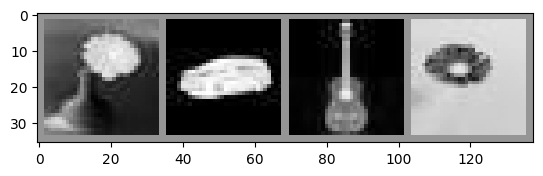

In [36]:
# extract a batch of 4 images
images, labels = next(iter(train_dataloader))
# create a grid from the images and display them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)

In [40]:
#8 representation, pca dan tsne
import numpy as np
from sklearn import decomposition
from sklearn import manifold
from tqdm.notebook import tqdm

import torch
import torch.nn.functional as F



def get_representations(model, dataloader, device):
    model.eval()

    outputs = []
    intermediates = []
    labels = []
    with torch.no_grad():
        for (x,y) in tqdm(dataloader):
            x = x.to(device)
            y_pred, h = model(x)
            outputs.append(y_pred.cpu())
            intermediates.append(h.cpu())
            labels.append(y)

    outputs = torch.cat(outputs, dim=0)
    intermediates = torch.cat(intermediates, dim=0)
    labels = torch.cat(labels, dim=0)

    return outputs, intermediates, labels


def get_pca(data, n_components=2):
    pca = decomposition.PCA()
    pca.n_components = n_components
    pca_data = pca.fit_transform(data)
    return pca_data


def get_tsne(data, n_components=2, n_images=None):
    if n_images is not None:
        data = data[:n_images]
    tsne = manifold.TSNE(n_components=n_components, random_state=0)
    tsne_data = tsne.fit_transform(data)
    return tsne_data




In [42]:
#9 plot confusion matrix, representations dan filtered images
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import torch
import torch.nn.functional as F



def plot_confusion_matrix(labels, pred_labels, num_classes):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(labels, pred_labels)
    cm = ConfusionMatrixDisplay(cm, display_labels=range(num_classes))
    cm.plot(values_format='d', cmap='Blues', ax=ax)



def plot_most_incorrect(incorrect, n_images):
    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(20,10))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        image, true_label, probs = incorrect[i]
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim=0)
        ax.imshow(image.view(28, 28).cpu().numpy(), cmap='bone')
        ax.set_title(f'true label: {true_label} ({true_prob:.3f})\n'
                     f'pred label: {incorrect_label} ({incorrect_prob:.3f})')
        ax.axis('off')

    fig.subplots_adjust(hspace=0.5)


def plot_representations(data, labels, n_images=None):
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:,0], data[:,1], c=labels, cmap='tab10')
    handles, labels = scatter.legend_elements()
    ax.legend(handles=handles, labels=labels)


def plot_filtered_images(images, filters):
    images = torch.cat([i.unsqueeze(0) for i in images], dim=0).cpu()
    filters = filters.cpu()

    n_images = images.shape[0]
    n_filters = filters.shape[0]

    filtered_images = F.conv2d(images, filters)

    fig = plt.figure(figsize=(20,10))

    for i in range(n_images):
        ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters))
        ax.imshow(images[i].squeeze(0), cmap='bone')
        ax.set_title('Original')
        ax.axis('off')

        for j in range(n_filters):
            image = filtered_images[i][j]
            ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters)+j+1)
            ax.imshow(image.numpy(), cmap='bone')
            ax.set_title(f'Filter {j+1}')
            ax.axis('off')
